In [15]:
!pip install xgboost


   ---------------------------------------- 0.0/150.0 MB ? eta -:--:--
   ---------------------------------------- 0.8/150.0 MB 5.6 MB/s eta 0:00:27
    --------------------------------------- 2.1/150.0 MB 5.9 MB/s eta 0:00:26
    --------------------------------------- 3.4/150.0 MB 6.1 MB/s eta 0:00:25
   - -------------------------------------- 4.7/150.0 MB 6.1 MB/s eta 0:00:24
   - -------------------------------------- 6.0/150.0 MB 6.1 MB/s eta 0:00:24
   - -------------------------------------- 7.3/150.0 MB 6.1 MB/s eta 0:00:24
   -- ------------------------------------- 8.7/150.0 MB 6.2 MB/s eta 0:00:23
   -- ------------------------------------- 10.0/150.0 MB 6.1 MB/s eta 0:00:23
   --- ------------------------------------ 11.3/150.0 MB 6.1 MB/s eta 0:00:23
   --- ------------------------------------ 12.3/150.0 MB 6.2 MB/s eta 0:00:23
   --- ------------------------------------ 13.9/150.0 MB 6.2 MB/s eta 0:00:22
   --- ------------------------------------ 14.9/150.0 MB 6.2 MB/s 

In [16]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error

from xgboost import XGBRegressor

import warnings
warnings.filterwarnings('ignore')

# Load data
train = pd.read_csv("C:/Users/RUDRANSH/Downloads/house-prices-advanced-regression-techniques/train.csv", index_col='Id')
test = pd.read_csv("C:/Users/RUDRANSH/Downloads/house-prices-advanced-regression-techniques/train.csv", index_col='Id')

# Log transform target
y = np.log1p(train['SalePrice'])
train.drop(columns='SalePrice', inplace=True)
all_data = pd.concat([train, test])


In [17]:

none_cols = ['Alley', 'PoolQC', 'Fence', 'MiscFeature', 'FireplaceQu',
             'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond',
             'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
             'MasVnrType']
for col in none_cols:
    all_data[col] = all_data[col].fillna('None')

zero_cols = ['GarageYrBlt', 'GarageArea', 'GarageCars',
             'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
             'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath',
             'MasVnrArea']
for col in zero_cols:
    all_data[col] = all_data[col].fillna(0)

# Fill remaining numerical and categorical columns
num_cols = all_data.select_dtypes(include=['int64', 'float64']).columns
cat_cols = all_data.select_dtypes(include='object').columns

for col in num_cols:
    all_data[col] = all_data[col].fillna(all_data[col].median())
for col in cat_cols:
    all_data[col] = all_data[col].fillna(all_data[col].mode()[0])


In [18]:

all_data['TotalSF'] = all_data['TotalBsmtSF'] + all_data['1stFlrSF'] + all_data['2ndFlrSF']
all_data['TotalBath'] = (all_data['BsmtFullBath'] + 0.5 * all_data['BsmtHalfBath'] +
                         all_data['FullBath'] + 0.5 * all_data['HalfBath'])
all_data['HouseAge'] = all_data['YrSold'] - all_data['YearBuilt']
all_data['RemodAge'] = all_data['YrSold'] - all_data['YearRemodAdd']

# Drop outliers or weak features
all_data.drop(['Utilities', 'Street', 'PoolQC'], axis=1, inplace=True)


In [19]:

X = all_data[:len(y)]
X_test = all_data[len(y):]

numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

numeric_pipeline = Pipeline([
    ('scaler', StandardScaler())
])

categorical_pipeline = Pipeline([
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer([
    ('num', numeric_pipeline, numeric_features),
    ('cat', categorical_pipeline, categorical_features)
])


In [20]:

# Step 5: Build and evaluate XGBoost with cross-validation

model = Pipeline([
    ('preprocess', preprocessor),
    ('regressor', XGBRegressor(n_estimators=500, learning_rate=0.05, max_depth=4, random_state=42))
])

# Cross-validation
cv_scores = cross_val_score(model, X, y, scoring='neg_root_mean_squared_error', cv=5)
print("Cross-Validated RMSE:", -cv_scores.mean())


Cross-Validated RMSE: 0.12506251103813387


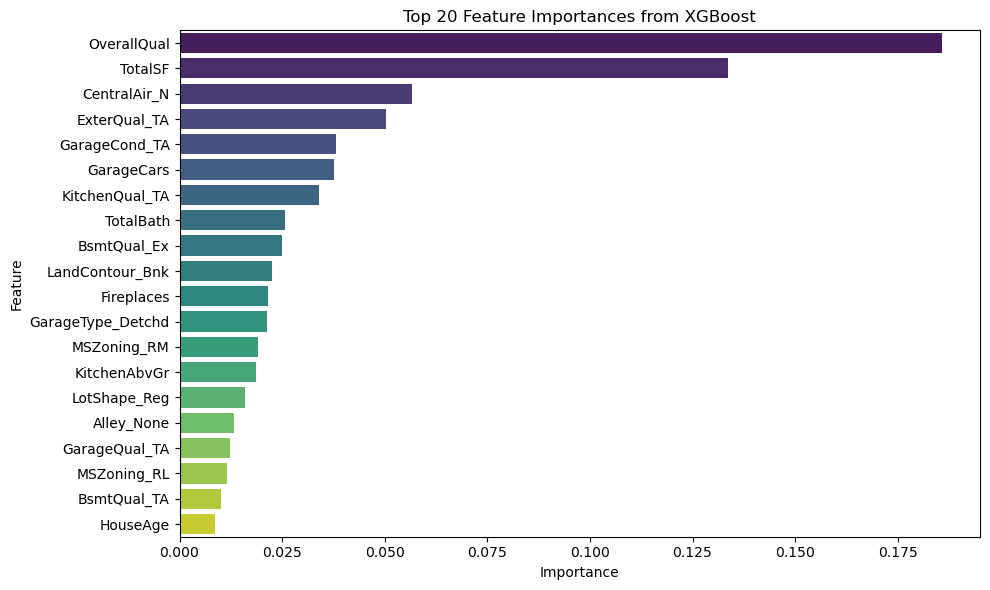

In [29]:

preprocessed = model.named_steps['preprocess']
cat_features = preprocessed.transformers_[1][1].named_steps['onehot'].get_feature_names_out(categorical_features)
feature_names = list(numeric_features) + list(cat_features)


importances = model.named_steps['regressor'].feature_importances_
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})


importance_df = importance_df.sort_values(by='Importance', ascending=False).head(20)

plt.figure(figsize=(10, 6))
sns.barplot(data=importance_df, x='Importance', y='Feature', palette='viridis')
plt.title("Top 20 Feature Importances from XGBoost")
plt.tight_layout()
plt.show()


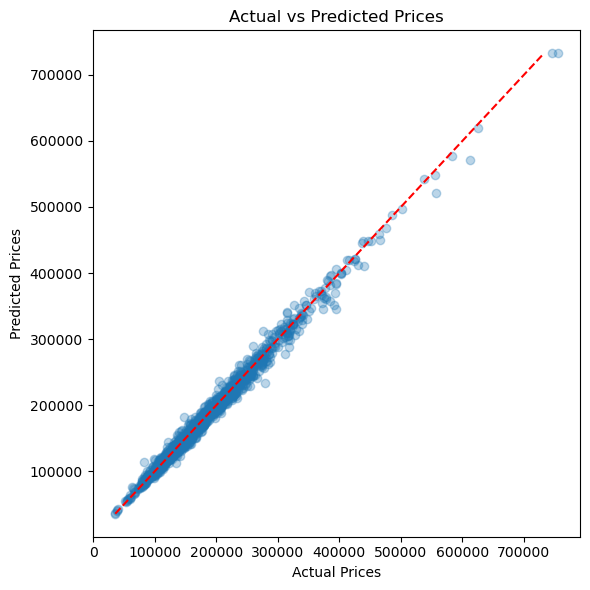

In [31]:
y_pred_log = model.predict(X)
y_pred_actual = np.expm1(y_pred_log)

plt.figure(figsize=(6, 6))
plt.scatter(np.expm1(y), y_pred_actual, alpha=0.3)
plt.plot([min(y_pred_actual), max(y_pred_actual)], [min(y_pred_actual), max(y_pred_actual)], 'r--')
plt.title("Actual vs Predicted Prices")
plt.xlabel("Actual Prices")
plt.ylabel("Predicted Prices")
plt.tight_layout()
plt.show()
